# GAN-ZT train final model
### This notebook contains the code need to train the final conditional generative adversarial network model using [0,1] encoded individual toxicity matrices and chemicals structural data.
#### See http://biorxiv.org/lookup/doi/10.1101/2020.10.02.322917 for details

By Adrian J Green, PhD

#### Import Tensorflow and manage GPUs

In [1]:
import os

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import multi_gpu_model

tf.keras.backend.clear_session()  # For easy reset of notebook state.

# minimize GPU useage by allowing memeory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


#### Import Python data handling and visualization modules, and local routines

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# standard python
import numpy as np
# from sklearn.metrics import mean_squared_log_error, mean_squared_error
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
import pathlib
import os.path
import warnings
import timeit

# plotting, especially for jupyter notebooks
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image

# pandas
import pandas as pd

# local routines
from chemdataprep import load_PDBs
from toxmathandler_AG import load_tmats, load_indv_tmats

# NN build routines
from NNbuild_train_vis import init_NN_v2

# NN train routines
from NNbuild_train_vis import discriminator_loss,generator_loss, get_train_function, write_training_file

# Performance evaluation routines
from gen_AggE import calc_AggE_indv, display_conf_matrix

print("tensorflow version",tf.__version__,". Executing eagerly?",tf.executing_eagerly())
print("Number of GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version 2.1.0 . Executing eagerly? True
Number of GPUs:  1


## Global Options and Variables

#### Chemical structure and toxicity import and model output variables

In [23]:
### PDB options

# cGAN & views parameters
# [Gfeatures,Gbaselayers,Glayers,Dfeatures,Dbaselayers,Dlayers,carbonbased, setNatoms, views, ClassLabels]
parameters = [279, 3, 11, 18, 0, 0, False, 82, 126, None] # GAN-ZT_v6

## Option to base views on carbon or not. (Safe even if some have no carbon.)
# Setting True will make the data smaller in memory and everything run faster.
carbonbased = parameters[6]
## Option for truncating the length of views.
# Truncating will make the data and NN smaller and things run faster.
# It make sense if we believe that looking at all neighborhoods of some size 
# gives sufficient understanding of the chemical.
# setNatoms = None # use max number in data
setNatoms = parameters[7] # truncate to this number

views=parameters[8]

dataType = '(0,1)_18x1'

if (dataType.find('(0,1)_18x6')!=-1):
    concentrations = [0,1,2,3,4,5]
else:
    concentrations = [5]    ## Which of the available endpoints to use
endpoints = [i for i in range(4,22)] # use all
    
genpath = 'AG-model-GT-'+dataType+'.h5'
discpath = 'AG-model-DT-'+dataType+'.h5'

# Traning individual toxic
trpath = '/home2/ajgreen4/Read-Across_w_GAN/DataFiles/(0,1)_encoding_indv/Tox21_training_compounds/'
valpath = '/home2/ajgreen4/Read-Across_w_GAN/DataFiles/(0,1)_encoding_indv/Tox21_validation_compounds/'
allpath = '/home2/ajgreen4/Read-Across_w_GAN/DataFiles/(0,1)_encoding_indv/Tox21_all_train_compounds/'
    
modelpath = '/home2/ajgreen4/Read-Across_w_GAN/Models/'
imageOut = '/home2/ajgreen4/Read-Across_w_GAN/imageOut/'

#### cGAN variables

In [4]:
# losses
Gloss_function = tf.keras.losses.MeanSquaredError()
Dloss_function = tf.keras.losses.MeanSquaredError()

# optimizers
generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

# Data Preparation

### Load chemical data and vectorize into weights and views

In [17]:
# load all training files
[ws, vs, Natoms, Nviews, chemnames, Vshape] = load_PDBs(allpath,setNatoms=setNatoms,setNviews=views,carbonbased=carbonbased) 
parameters[8] = Nviews
useClassLabels = parameters[9] = len(chemnames) # allow cGAN to use class labels in training, None or int

1003 pdb files found at /home2/ajgreen4/Read-Across_w_GAN/DataFiles/(0,1)_encoding_indv/Tox21_all_train_compounds/PDBs/
Species occurring = {'S', 'N', 'F', 'I', 'O', 'BR', 'P', 'H', 'CL', 'SI', 'B', 'C', 'AS'}
Setting all views to Natoms= 82
126 views needed, but setting to 126
Maximum views used = 126
Data tensor (w,v) shapes= (1003, 126) (1003, 126, 410)


#### Encode chemical labels

In [18]:
chem_labels = np.arange(len(chemnames))
chem_labels = np.reshape(chem_labels, (chem_labels.shape[0],1))

#### Load individual toxicity data

In [19]:
%%time

# individual toxicity
print("Loading individual toxicity matrices (~15 minutes)")
### Toxicity matrix options
[toxicity,rows, cols, fish] = load_indv_tmats(allpath,chemnames,endpoint_indexes=endpoints,
                                              SET=2, verbose=1)

Xfactor = np.bincount(fish[:,0])

# legend labels for plotting
print("Using", len(concentrations), "concentrations")
print("Using", len(endpoints), "endpoints")
endpoints = [i for i in range(len(rows))]
concentrations = [i for i in range(len(cols))]
legend = [rows,cols,endpoints,concentrations]
    
if 0:
    print('CASRN: ',chemnames[0])
    print('Chem label: ',fish[0])
    print('First tox matrix:', toxicity[0])
    


Loading individual toxicity matrices (~15 minutes)
Number of chemicals= 1003
Using concentrations ['64 uM']
Using endpoints: ['MORT', 'YSE_', 'AXIS', 'EYE_', 'SNOU', 'JAW_', 'OTIC', 'PE__', 'BRAI', 'SOMI', 'PFIN', 'CFIN', 'PIG_', 'CIRC', 'TRUN', 'SWIM', 'NC__', 'TR__']
Toxicity vector length Ntoxicity= 18
Using 1 concentrations
Using 18 endpoints
CPU times: user 15min 9s, sys: 1.53 s, total: 15min 11s
Wall time: 15min 18s


# Neural Network training code

In [8]:
# Create wrapper function to allow model to be discarded and re-initilazation between cross-validation folds
def get_train_function():
    # Compile training function
    @tf.function
    def train_step(G_data,real_data,chemClass,toxClass,doG=True,doD=True):
        """Train Condictional Generative Adversarial Network.

        :parameter G_data: List containing a np.array vector with weights and 
                           a np.array matrix with vectorized views.
                           (see chemdataprep.load_pdb())
        :type G_data: list
        :parameter real_data: Master toxicity data matrix. 
                              Rows correspond to chemicals and columns to toxicity measurements.
                              (see toxmathandler.load_tmats())
        :type real_data: np.array
        :parameter chemClass: Chemical class label.
        :type chemClass: int
        :parameter toxClass: Toxcicity class labels.
        :type toxClass: int
        :parameter doG: If True train generator
        :type doG: boolean
        :parameter doD: If True train discriminator
        :type doD: boolean

        :returns: Discriminator and Generator loss
        :rtype: tuple

        """
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_matrix, Gpw_features = generator(G_data+chemClass, training=True)
            expanded_Dpw_model = tf.repeat(Gpw_features, repeats=Xfactor, axis=0)

            real_output = discriminator([expanded_Dpw_model]+real_data+toxClass, training=True)
            fake_output = discriminator([Gpw_features]+[generated_matrix]+chemClass, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

            if doD:
                # update discriminator
                gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                # Additional training
                for i in range(2):
                    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                        generated_matrix, Gpw_features = generator(G_data+chemClass, training=False)
                        expanded_Dpw_model = tf.repeat(Gpw_features, repeats=Xfactor, axis=0)

                        real_output = discriminator([expanded_Dpw_model]+real_data+toxClass, training=True)
                        fake_output = discriminator([Gpw_features]+[generated_matrix]+chemClass, 
                                                    training=True)


                        gen_loss = generator_loss(fake_output)
                        disc_loss = discriminator_loss(real_output, fake_output)

                    # update discriminator
                    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
                    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            if doG:
                # update generator
                gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        return (gen_loss,disc_loss)
    return train_step

In [9]:
# Initialize the cGAN
doG = 1
doD = 1

# Initialize the G & D netowrks  
[generator, discriminator] = init_NN_v2([ws, vs],toxicity,parameters)
generator.summary()
discriminator.summary()

train_step = get_train_function()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gen_class_label (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
parallelwrapper_input0 (InputLa [(None, 126, 410)]   0                                            
__________________________________________________________________________________________________
gen_class_embedding (Embedding) (None, 1, 50)        52950       gen_class_label[0][0]            
__________________________________________________________________________________________________
gen_chem_feature_base (Model)   (None, 126, 279)     1428021     parallelwrapper_input0[0][0]     
__________________________________________________________________________________________

In [10]:
%%time
# cGAN training loop
epochs = 2000
best_kappa = 0
training_loss = np.zeros((epochs,2))
# Find Sweet spot
j = 0
while j < epochs:
    info = train_step([ws, vs],[toxicity],[chem_labels],[fish],doG,doD)

    # find out how well the two NNs are doing
    gen_lab, Gchem_features = generator.predict([ws,vs,chem_labels])
    expanded_Dpw_model = tf.repeat(Gchem_features, repeats=Xfactor, axis=0)

    fake_output = discriminator.predict([Gchem_features,gen_lab,chem_labels])
    gen_ability_T = Dloss_function(tf.zeros_like(fake_output), fake_output).numpy()

    real_output = discriminator.predict([expanded_Dpw_model,toxicity,fish])
    disc_ability_T = Dloss_function(tf.ones_like(real_output), real_output).numpy()

    doG = 1
    doD = 1

    # if G is winning stop training G
    if (disc_ability_T-gen_ability_T) < 0 or gen_ability_T > 0.95:
        doG = 0
    # if D is winning stop training D
    if disc_ability_T > 0.95:
        doD = 0
    if gen_ability_T > 0.90 and disc_ability_T > 0.90:
        doG = 1
        doD = 1          

    # Calculate chemical activity - ignoring warning due to potential division by zero
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=Warning)
        [gen_activity_table, tox_activity_table, gen_AggE, tox_AggE] = calc_AggE_indv(toxicity, chem_labels, 
                                                                                      chemnames, gen_lab, 
                                                                                      fish, endpoints, Xfactor)

        metrics = display_conf_matrix(gen_activity_table, tox_activity_table, Display=0)
    model_kappa = metrics[0]

    if model_kappa > best_kappa:
        best_kappa = model_kappa
        best_metrics = metrics

        # find out how well the two NNs are doing
        print("\nTraining Dataset")
        print('    Kappa: ', metrics[0], '  AUROC: ', metrics[1], '    SE', metrics[2])
        print("gen_ability:", gen_ability_T, " disc_ability:", disc_ability_T)
        print("Training State: doG =", doG, ", doD =", doD, " j = ", j, "\n")

        # Save the model
        generator.save(modelpath+genpath)
        discriminator.save(modelpath+discpath)

    if j % 50 == 0:
        print(j, end=" ")

    training_loss[j] = [gen_ability_T, disc_ability_T]
    j += 1

# Load the best model
generator = tf.keras.models.load_model(modelpath+genpath)
discriminator = tf.keras.models.load_model(modelpath+discpath)


Training Dataset
    Kappa:  0.058   AUROC:  0.5626     SE 81.5
gen_ability: 0.027105574  disc_ability: 1.2339292
Training State: doG = 1 , doD = 0  j =  0 

0 
Training Dataset
    Kappa:  0.086   AUROC:  0.5737     SE 62.4
gen_ability: 0.8073348  disc_ability: 0.8413325
Training State: doG = 1 , doD = 1  j =  1 


Training Dataset
    Kappa:  0.088   AUROC:  0.5525     SE 35.4
gen_ability: 0.30865723  disc_ability: 0.49060825
Training State: doG = 1 , doD = 1  j =  22 

50 100 
Training Dataset
    Kappa:  0.09   AUROC:  0.5434     SE 23.3
gen_ability: 0.20457299  disc_ability: 0.40493447
Training State: doG = 1 , doD = 1  j =  147 

150 200 250 300 350 
Training Dataset
    Kappa:  0.113   AUROC:  0.5745     SE 44.4
gen_ability: 0.102041975  disc_ability: 0.62496877
Training State: doG = 1 , doD = 1  j =  356 

400 450 500 550 600 650 
Training Dataset
    Kappa:  0.116   AUROC:  0.6036     SE 70.4
gen_ability: 0.03379729  disc_ability: 0.658567
Training State: doG = 1 , doD = 1  j

In [31]:
# Save the model
best_kappa_f = str(round(best_kappa,5))

print("AG-model-GT-"+dataType+"-Kappa-"+best_kappa_f+".h5")
generator.save(modelpath+"AG-model-GT-"+dataType+"-Kappa-"+best_kappa_f+".h5")
print("AG-model-DT-"+dataType+"-Kappa-"+best_kappa_f+".h5")
discriminator.save(modelpath+"AG-model-DT-"+dataType+"-Kappa-"+best_kappa_f+".h5")

model_ID = "AG-model-GT-"+dataType+"-Kappa-"+best_kappa_f+".h5"

AG-model-GT-(0,1)_18x1-Kappa-0.144.h5
AG-model-DT-(0,1)_18x1-Kappa-0.144.h5


#### Display run summary information

Chemical Information:
Data tensor (w,v) shapes = (1003, 126) (1003, 126, 410)
Only use Carbon atoms: False
Number of atoms per view: 82
Views per chemical: 126

Network Information:
Gfeatures = 279
Gbaselayers = 3
Glayers = 11
Dfeatures = 50
Dbaselayers = 0
Dlayers = 3

(0,1)_18x1 Dataset



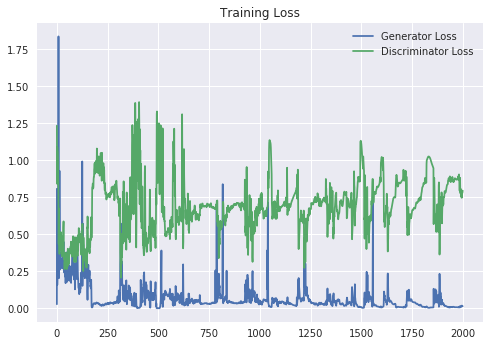



Kappa:  0.144
Auroc:  0.6067


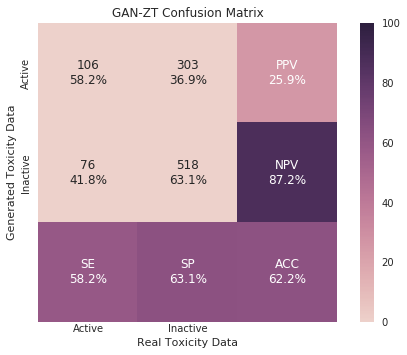

In [32]:
print("Chemical Information:\n"+
             "Data tensor (w,v) shapes = "+str(ws.shape)+" "+str(vs.shape)+
             "\nOnly use Carbon atoms: "+str(parameters[6])+
             "\nNumber of atoms per view: "+str(parameters[7])+
             "\nViews per chemical: "+str(parameters[8])+
             "\n\nNetwork Information:"+
             "\nGfeatures = "+str(parameters[0])+"\nGbaselayers = "+str(parameters[1])+
             "\nGlayers = "+str(parameters[2])+"\nDfeatures = "+str(parameters[3])+
             "\nDbaselayers = "+str(parameters[4])+"\nDlayers = "+str(parameters[5])+
             "\n\n"+dataType+" Dataset\n")


gen_lab, Gchem_features = generator.predict([ws,vs,chem_labels])
expanded_Dpw_model = tf.repeat(Gchem_features, repeats=Xfactor, axis=0)

fake_output = discriminator.predict([Gchem_features,gen_lab,chem_labels])
gen_ability = Dloss_function(tf.zeros_like(fake_output), fake_output).numpy()

real_output = discriminator.predict([expanded_Dpw_model,toxicity,fish])
disc_ability = Dloss_function(tf.ones_like(real_output), real_output).numpy()

if 1:    
    # plot loss during training
    plt.figure()
    plt.title('Training Loss')
    plt.plot(training_loss[:,0], label='Generator Loss')
    plt.plot(training_loss[:,1], label='Discriminator Loss')
    plt.legend()
    plt.savefig(modelpath+'GAN-ZT_final_model_loss_plot-'+best_kappa_f+'.png', dpi=600, bbox_inches='tight')
    plt.pause(0.5)
    
# Calculate chemical activity - ignoring warning due to potential division by zero
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=Warning)
    [gen_activity_table, tox_activity_table, gen_AggE, tox_AggE] = calc_AggE_indv(toxicity, chem_labels, chemnames, 
                                                              gen_lab, fish, endpoints, Xfactor, verbose=0)
    
metrics = display_conf_matrix(gen_activity_table, tox_activity_table, Gmodelname='GAN-ZT Training', Display=True, 
                              Save_path=modelpath)       
# metrics = display_conf_matrix(gen_activity_table, tox_activity_table, Gmodelname='GAN-ZT Training', Display=True)      

#### Write run summary to file

In [34]:
model_ID = "AG-model-GT-"+dataType+"-Kappa-"+best_kappa_f+"-GAN-ZT-final"

summary_file_df = write_training_file(parameters,[model_ID, concentrations, ws.shape[1], gen_ability, disc_ability],
                              best_metrics, modelpath+'GAN-ZT-Final-model-parameters-'+best_kappa_f+'.xlsx')

In [35]:
summary_file_df.head(40)

,ID,Number of Conc.,Views,Atoms per View,Gen Parameters,Disc Parameters,Gen Ability - Val,Disc Ability - Val,SE,SP,PPV,Kappa,AUROC
0,"AG-model-GT-(0,1)_18x1-Kappa-0.144-GAN-ZT-final",1,126,82,279 3 11,50 0 3,0.044421,0.761525,58.2,63.1,25.9,0.144,0.6067


# 